LSTM for Text Classification — Step-by-Step Implementation

This notebook demonstrates how to build, train, evaluate, and save a Long Short-Term Memory (LSTM) model for news category classification.
It covers preprocessing, tokenization, model design, training visualization, and prediction testing.

Step 1: Install and Import Required Libraries

This cell installs all the required libraries and imports the necessary Python modules for data handling, model creation, and evaluation.

In [1]:
!pip install tensorflow keras pandas scikit-learn seaborn -q

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


Step 2: Load and Explore the Dataset

This cell loads the preprocessed dataset, explores its structure, checks label distribution, and visualizes text length distribution.

Dataset shape: (30000, 3)

Columns: ['text', 'category', 'label']

First few rows:
                                                text       category  label
0  ethan hawke julie delpy pick left midnight eth...  ENTERTAINMENT      3
1  tom cruise forced choose scientology suri tom ...  ENTERTAINMENT      3
2  would pay wine beer glass made cheese heart me...  ENTERTAINMENT      3
3                    tyga denies dating kylie jenner  ENTERTAINMENT      3
4  review laughfest subversively family friendly ...  ENTERTAINMENT      3

Unique categories: 15

Label distribution:
label
0     2000
1     2000
2     2000
3     2000
4     2000
5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
13    2000
14    2000
Name: count, dtype: int64

Text length statistics:
count    30000.000000
mean        17.633600
std          7.196968
min          5.000000
25%         13.000000
50%         17.000000
75%         22.000000
max        108.000000
Name: text_length, dtype:

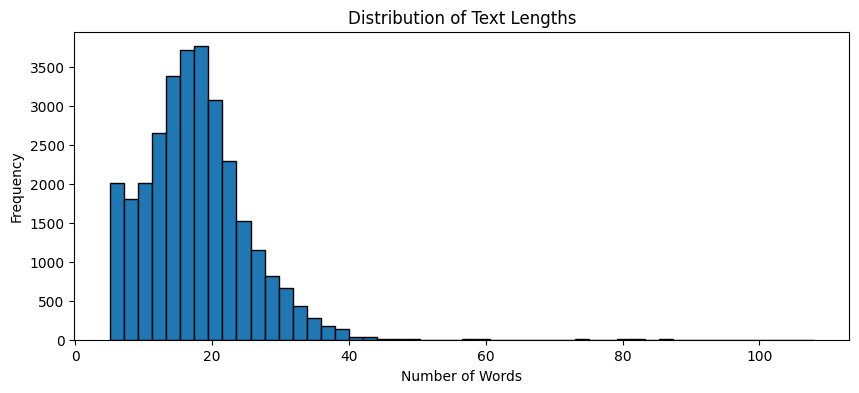

In [2]:
# Load data
df = pd.read_csv('news_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nUnique categories: {df['category'].nunique()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

# Check text lengths
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
print(f"\nText length statistics:")
print(df['text_length'].describe())

plt.figure(figsize=(10, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()


Step 3: Prepare the Data

This cell splits the dataset into training, validation, and test sets to ensure proper model evaluation.

In [3]:
# Parameters
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 128

texts = df['text'].astype(str).tolist()
labels = df['label'].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 24000
Validation samples: 3000
Test samples: 3000


Step 4: Tokenization and Padding

This cell converts text data into numeric sequences and pads them to a fixed length for LSTM input.

In [4]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train_pad.shape}")

num_classes = len(np.unique(labels))
print(f"Number of classes: {num_classes}")


Vocabulary size: 30903
Training data shape: (24000, 200)
Number of classes: 15


Step 5: Build the LSTM Model

This cell defines the LSTM model architecture with embedding, dropout, and dense layers.

In [5]:
def build_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        layers.SpatialDropout1D(0.3),
        layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_lstm_model(MAX_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, num_classes)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

🧠 Step 6: Compile the Model

This cell compiles the model using Adam optimizer and sparse categorical cross-entropy loss

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("✅ Model compiled successfully!")


✅ Model compiled successfully!


Step 7: Configure Training Callbacks

This cell sets up early stopping, model checkpointing, and learning rate reduction callbacks to optimize training.

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]
print("✅ Callbacks configured!")


✅ Callbacks configured!


Step 8: Train the Model

This cell trains the LSTM model using the training data and validates performance on the validation set.

In [9]:
print("🚀 Starting training...\n")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


🚀 Starting training...

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.0617 - loss: 2.7081
Epoch 1: val_accuracy did not improve from 0.06667
375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 348ms/step - accuracy: 0.0618 - loss: 2.7081 - val_accuracy: 0.0667 - val_loss: 2.7081 - learning_rate: 3.1250e-05
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.0713 - loss: 2.7081
Epoch 2: val_accuracy did not improve from 0.06667
375/375 ━━━━━━━━━━━━━━━━━━━━ 133s 355ms/step - accuracy: 0.0713 - loss: 2.7081 - val_accuracy: 0.0667 - val_loss: 2.7081 - learning_rate: 3.1250e-05
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.0634 - loss: 2.7081
Epoch 3: val_accuracy did not improve from 0.06667
375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 350ms/step - accuracy: 0.0634 - loss: 2.7081 - val_accuracy: 0.0667 - val_loss: 2.7081 - learning_rate: 3.1250e-05
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.0682 - loss: 2.7080
Epoch 4: val_accuracy di

📊 Step 9: Visualize Training History

This cell plots accuracy and loss trends to monitor model performance over epochs.

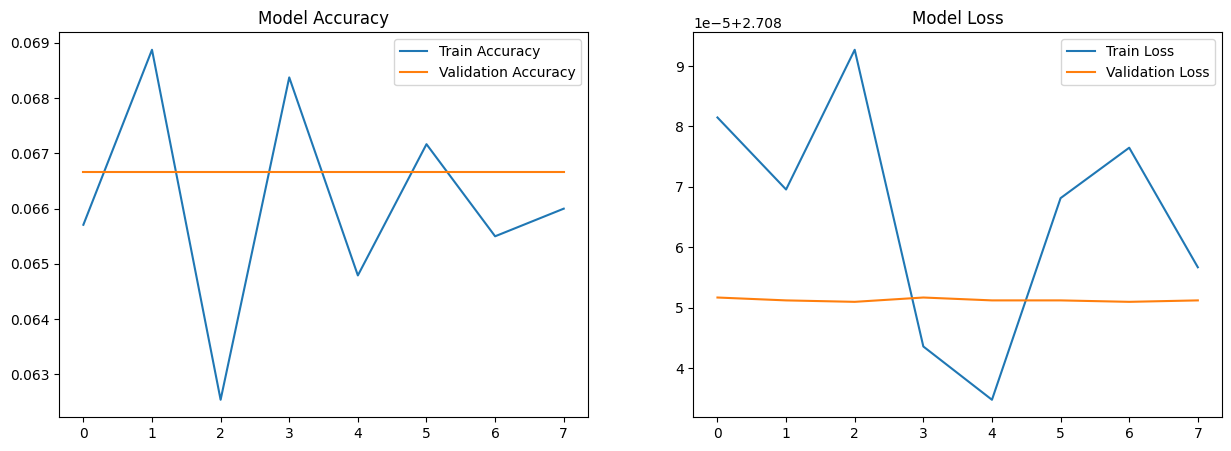

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].legend()

plt.show()


🧾 Step 10: Evaluate the Model on Test Data

This cell loads the best model and evaluates it on the test set for accuracy and classification metrics.

In [11]:
model.load_weights('best_lstm_model.h5')

test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Loss: 2.7082
Test Accuracy: 0.0667 (6.67%)
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       200
           2       0.07      1.00      0.12       200
           3       0.00      0.00      0.00       200
           4       0.00      0.00      0.00       200
           5       0.00      0.00      0.00       200
           6       0.00      0.00      0.00       200
           7       0.00      0.00      0.00       200
           8       0.00      0.00      0.00       200
           9       0.00      0.00      0.00       200
          10       0.00      0.00      0.00       200
          11       0.00      0.00      0.00       200
          12       0.00      0.00      0.00       200
          13       0.00      0.00      0.00       200
          14       0.00      0.00      0.00       200

    accuracy          

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔍 Step 11: Confusion Matrix Visualization

This cell visualizes how well the model classified each category.

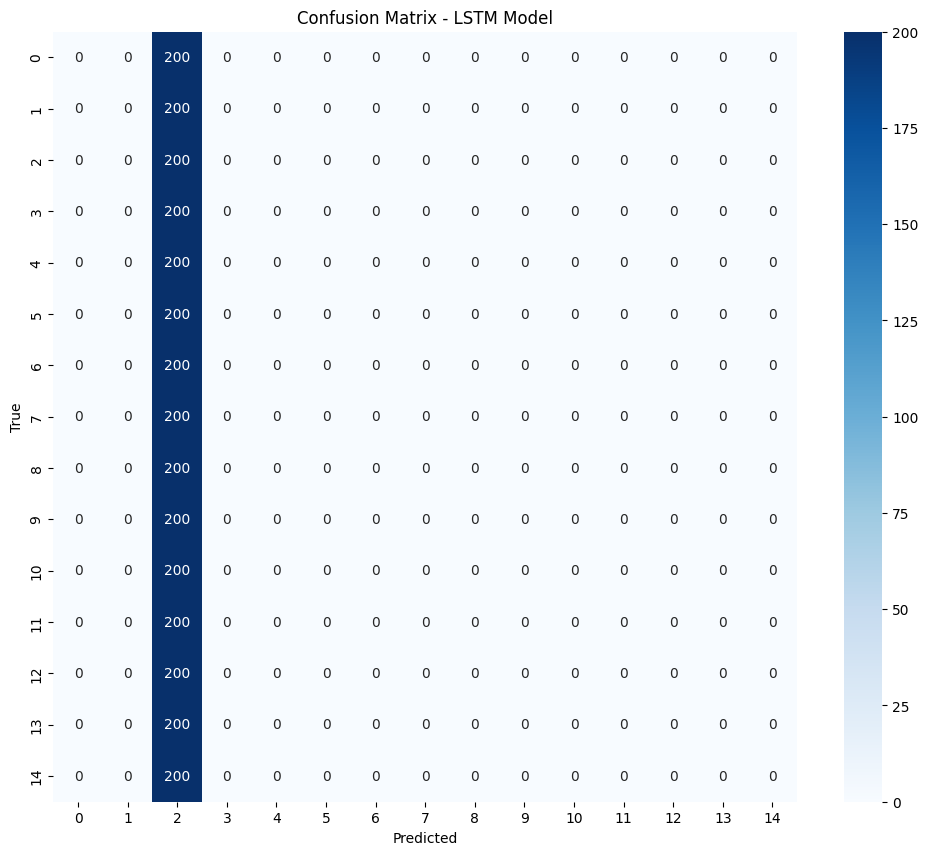

In [12]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LSTM Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


💾 Step 12: Save the Model and Tokenizer

This cell saves the trained model, tokenizer, and configurations for future use.

In [13]:
model.save('lstm_news_classifier.h5')

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'num_classes': num_classes
}
with open('lstm_config.pkl', 'wb') as f:
    pickle.dump(config, f)

print("✅ Model, tokenizer, and config saved successfully!")


✅ Model, tokenizer, and config saved successfully!


Step 13: Make Predictions

This cell defines a function to predict text categories using the trained model.

In [14]:
def predict_text(text, model, tokenizer, label_mapping, max_length):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = model.predict(padded)
    pred_label = np.argmax(prediction)
    category = label_mapping[label_mapping['label'] == pred_label]['category'].values[0]
    print(f"📰 Text: {text[:100]}...")
    print(f"🔮 Predicted Category: {category}")

# Example prediction
predict_text("Breaking news about political developments in Washington", model, tokenizer, df[['category','label']], MAX_SEQUENCE_LENGTH)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
📰 Text: Breaking news about political developments in Washington...
🔮 Predicted Category: CRIME


Step 14: Reload the Saved Model and Tokenizer

This cell demonstrates how to reload your saved model, tokenizer, and configuration for future predictions — without retraining the model from scratch.

In [15]:
# Reload the saved model and tokenizer
from tensorflow.keras.models import load_model

# Load model
reloaded_model = load_model('lstm_news_classifier.h5')
print("✅ Model reloaded successfully!")

# Load tokenizer and config
with open('tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)

with open('lstm_config.pkl', 'rb') as f:
    loaded_config = pickle.load(f)

print("✅ Tokenizer and configuration reloaded successfully!")

# Confirm configuration
print(f"Loaded configuration:\n{loaded_config}")


✅ Model reloaded successfully!
✅ Tokenizer and configuration reloaded successfully!
Loaded configuration:
{'MAX_WORDS': 10000, 'MAX_SEQUENCE_LENGTH': 200, 'EMBEDDING_DIM': 128, 'num_classes': 15}


🧩 Step 15: Try an Advanced Model Variant (Bidirectional LSTM)

This cell shows how to extend your LSTM model using a Bidirectional LSTM layer for better performance by processing text in both forward and backward directions.

In [16]:
def build_bidirectional_lstm(vocab_size, embedding_dim, max_length, num_classes):
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        layers.Bidirectional(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile bidirectional model
bi_lstm_model = build_bidirectional_lstm(
    loaded_config['MAX_WORDS'],
    loaded_config['EMBEDDING_DIM'],
    loaded_config['MAX_SEQUENCE_LENGTH'],
    loaded_config['num_classes']
)

bi_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

bi_lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)